In [11]:
# Import necessary packages and suppress warnings


import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import seaborn as sns
import warnings
import gzip
import json
import os
import time
import math
import requests

#Soccer specific packages
from statsbombpy import sb
from mplsoccer import Pitch
from mplsoccer import VerticalPitch

#modeling packages
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, cross_val_predict
from sklearn import metrics 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('FBRefData.csv')
df.columns

Index(['Rk', 'Squad', 'MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Pts/MP',
       'xG', 'xGA', 'xGD', 'xGD/90', 'League', 'target', 'G/PG', 'GC/PG',
       'xG/PG', 'xGA/PG', 'Top_Team_Scorer'],
      dtype='object')

In [20]:
y = df['target']
X = df.drop(['MP', 'Squad', 'Rk', 'League', 'target', 'W', 'D', 'L', 'Pts', 'Pts/MP'], axis=1)

In [21]:
y.value_counts()

1    2520
0     800
2     720
Name: target, dtype: int64

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create a pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier())
])

#Train the model using the pipeline
pipeline.fit(X_train, y_train)

#Evaluate the model using AUC-ROC
test_predictions = pipeline.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, test_predictions, multi_class='ovo')
print(f"Test AUC-ROC Score: {auc_roc}")

Test AUC-ROC Score: 1.0


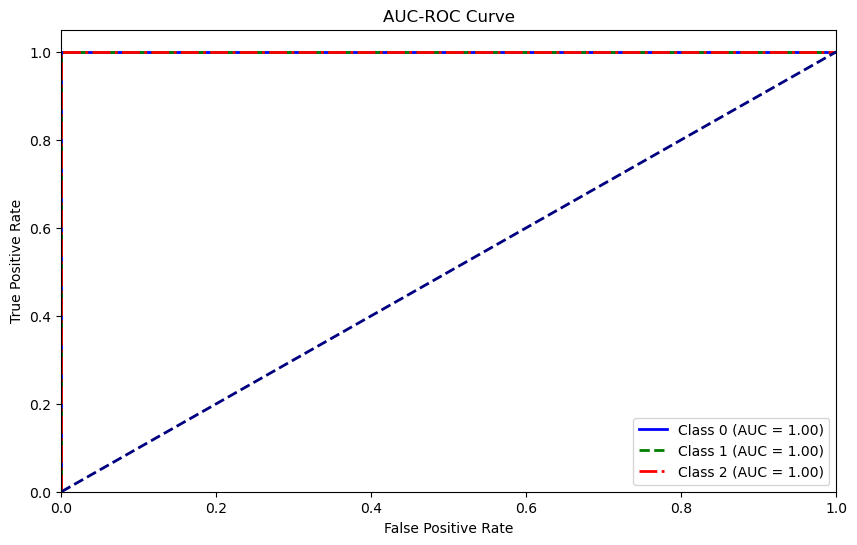

In [28]:
# Step 1: Predict probabilities on the test set
test_probabilities = pipeline.predict_proba(X_test)

# Step 2: Compute ROC curve and AUC for each class
n_classes = test_probabilities.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, test_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot the ROC curve
plt.figure(figsize=(10, 6))

# Define a list of line styles and colors for plotting
line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(n_classes):
    style_index = i % len(line_styles)  # Cycle through line styles
    color_index = i % len(colors)        # Cycle through colors
    
    plt.plot(fpr[i], tpr[i], lw=2, linestyle=line_styles[style_index], color=colors[color_index], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

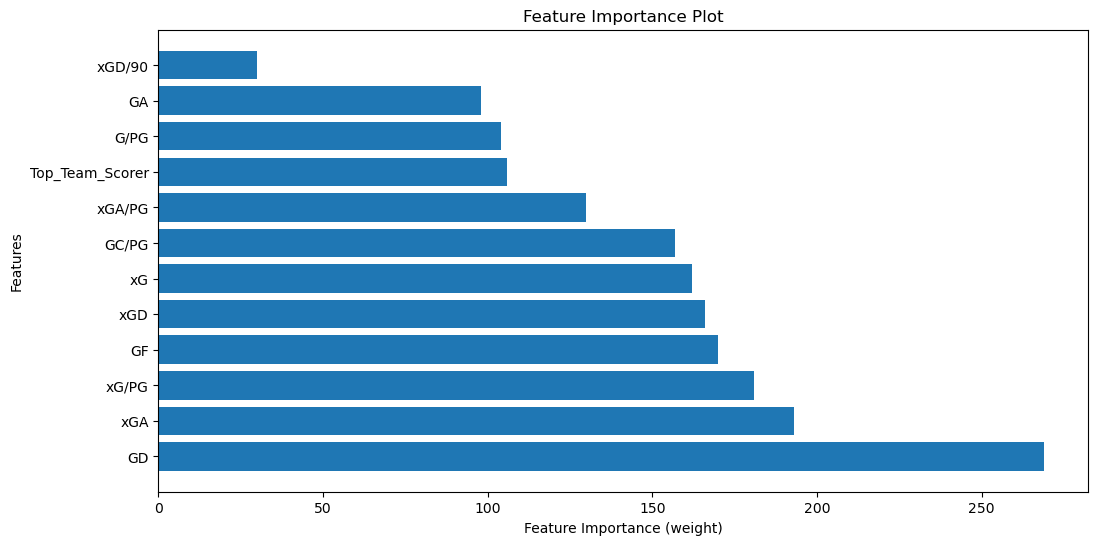

In [27]:
# Access the XGBoost model from the pipeline
xgboost_model = pipeline.named_steps['classifier']

# Get feature importance
importance_type = "weight"  # Other options: "gain", "cover"
feature_importance = xgboost_model.get_booster().get_score(importance_type=importance_type)

# Map feature importance names to their original column names
original_feature_names = X_train.columns  # Assuming X_train is a DataFrame
feature_importance_with_names = {original_feature_names[int(k[1:])] : v for k, v in feature_importance.items()}

# Create a bar plot to visualize feature importance
sorted_feature_importance = sorted(feature_importance_with_names.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*sorted_feature_importance)

plt.figure(figsize=(12, 6))
plt.barh(range(len(features)), importances, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel(f'Feature Importance ({importance_type})')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7]
}

# Create GridSearchCV with AUC-ROC scoring
grid_search = GridSearchCV(pipeline, param_grid, scoring='roc_auc', cv=5)

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Access the best estimator and best score
best_estimator = grid_search.best_estimator_
best_score = grid_search.best_score_
print(f"Best AUC-ROC Score: {best_score}")
